In [1]:
import pickle
from scipy.stats import combine_pvalues
import random
import matplotlib.pyplot as plt
from statistics import mean
import numpy as np

In [2]:
with open('fit_lll_all.pkl', 'rb') as handle:
    lll = pickle.load(handle)
with open('fit_lbl_all.pkl', 'rb') as handle:
    lbl = pickle.load(handle)
with open('fit_blb_all.pkl', 'rb') as handle:
    blb = pickle.load(handle)

In [3]:
n_data = len(lll["pvalues"][0])
n_model = len(lll["combined"])
print("Number of Lung Control Data", n_data)
print("Number of Lung Edges/Models", n_model)

Number of Lung Control Data 603
Number of Lung Edges/Models 100000


In [4]:
n_data = len(blb["pvalues"][0])
n_model = len(blb["combined"])
print("Number of Breast Control Data", n_data)
print("Number of Breast Edges/Models", n_model)

Number of Breast Control Data 513
Number of Breast Edges/Models 94547


In [5]:
def plot_tissue_comparison_c_pvalue(m, n, comp_a, comp_b, label_a, label_b):
    c_list_a = []
    c_list_b = []

    n_data = min(len(comp_a["pvalues"][0]),len(comp_b["pvalues"][0]))
    n_model = min(len(comp_a["combined"]),len(comp_b["combined"]))
    
    random_models = random.sample(range(n_model), m)

    for model in random_models:
        # Randomly select n control data to fit 
        random_data = random.sample(range(n_data), n)

        _, combined_a = combine_pvalues(comp_a["pvalues"][model][random_data], method='fisher')
        c_list_a.append(combined_a)

        _, combined_b = combine_pvalues(comp_b["pvalues"][model][random_data], method='fisher')
        c_list_b.append(combined_b)

    # Create the scatter plot
    plt.figure(figsize=(8, 6))

    # Scatter points for each list
    plt.scatter(range(m), c_list_a, label=label_a, color='green', alpha=0.7, s=10)
    plt.scatter(range(m), c_list_b, label=label_b, color='red', alpha=0.7, s=10)

    # Add a horizontal line for p-value 0.05
    plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (p=0.05)')

    # Add labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('Combined p-value')
    plt.title('Comparison of Combined p-values Across Models')
    plt.legend()

    # Show grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the plot
    plt.tight_layout()
    plt.show()


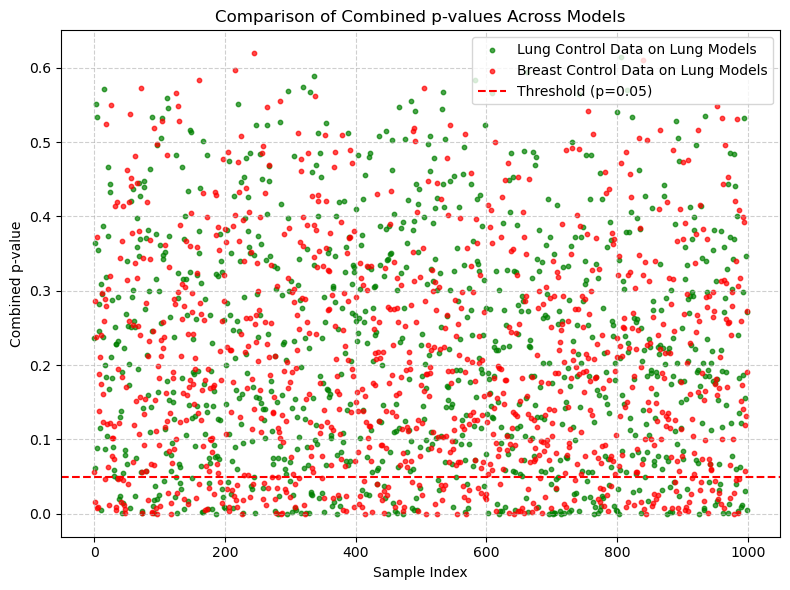

In [6]:
plot_tissue_comparison_c_pvalue(1000, 3, lll, blb, 
                       "Lung Control Data on Lung Models", 
                       "Breast Control Data on Lung Models")


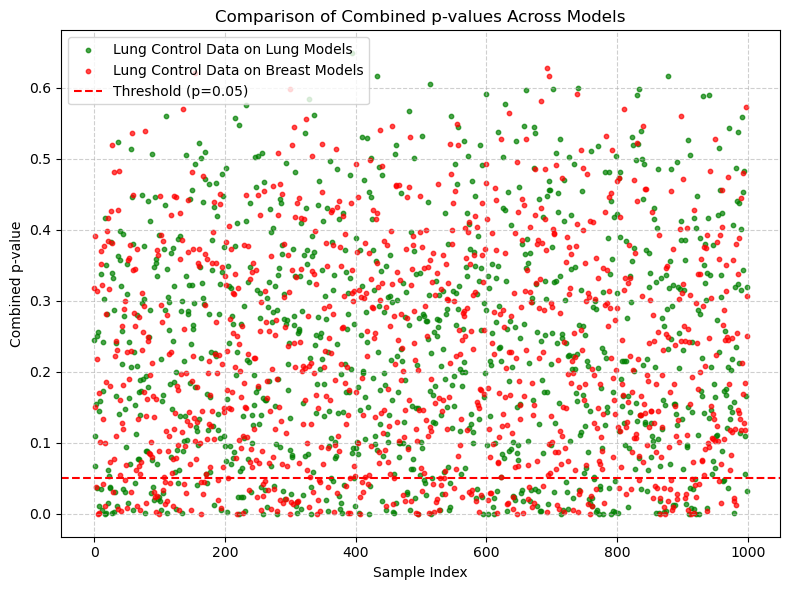

In [7]:
plot_tissue_comparison_c_pvalue(1000, 3, lll, lbl, 
                       "Lung Control Data on Lung Models", 
                       "Lung Control Data on Breast Models")


In [8]:
def plot_tissue_comparison_mean(m, n, comp_a, comp_b, label_a, label_b, metric, min_size=5, scale=75, log_transform=False):
    z_list_a = []
    z_list_b = []

    n_data = min(len(comp_a["pvalues"][0]), len(comp_b["pvalues"][0]))
    n_model = min(len(comp_a["combined"]), len(comp_b["combined"]))

    random_models = random.sample(range(n_model), m)

    for model in random_models:
        # Randomly select n control data to fit 
        random_data = random.sample(range(n_data), n)

        z_a = mean(abs(comp_a[metric][model][random_data]))
        z_list_a.append(z_a)

        z_b = mean(abs(comp_b[metric][model][random_data]))
        z_list_b.append(z_b)

    if log_transform:
        metric = "Log-transformed " + metric
        z_list_a = np.log1p(z_list_a)  # log(1+x) transformation
        z_list_b = np.log1p(z_list_b)

    # Calculate dynamic point size based on the number of points
    num_points = len(z_list_a) + len(z_list_b)
    point_size = max(min_size, scale / np.sqrt(num_points))

    # Add jitter to x-coordinates to reduce overlap
    jitter = lambda x: x + np.random.uniform(-0.2, 0.2, size=len(x))
    x_a = jitter(range(m))
    x_b = jitter(range(m))

    # Create the scatter plot
    plt.figure(figsize=(8, 6))

    # Scatter points for each list with dynamic size and jitter
    plt.scatter(x_b, z_list_b, label=label_b, color='red', alpha=0.6, s=point_size)
    plt.scatter(x_a, z_list_a, label=label_a, color='green', alpha=0.6, s=point_size)
    
    plt.axhline(y=mean(z_list_b), color='red', linestyle='--', 
                label='Overall '+metric+' Mean of '+ label_a)
    plt.axhline(y=mean(z_list_a), color='green', linestyle='--', 
                label='Overall '+metric+' Mean of '+ label_b)


    # Add labels and title
    plt.xlabel('Model Index (with jitter)')
    plt.ylabel(f"{metric} Mean")
    plt.title(f"Comparison of {metric} Means Across Models")
    plt.legend()

    # Show grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the plot
    plt.tight_layout()
    plt.show()


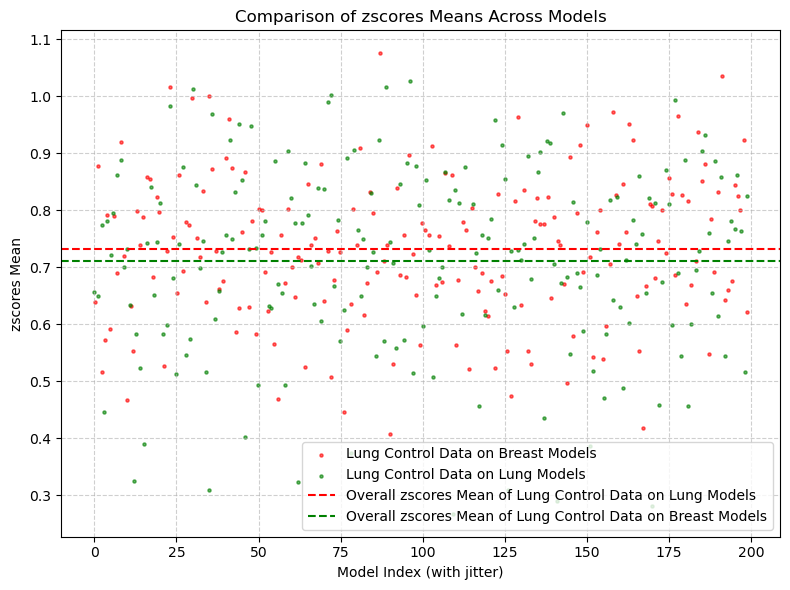

In [9]:
# Number of Models: 200 
# Number of control data to inclued per model: 30
plot_tissue_comparison_mean(200, 30, lll, lbl, 
                       "Lung Control Data on Lung Models", 
                       "Lung Control Data on Breast Models",
                       "zscores")


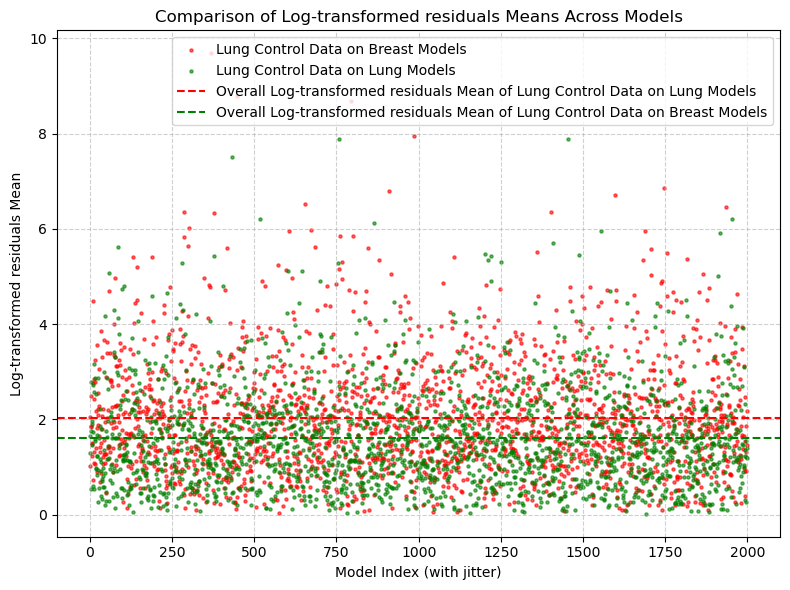

In [10]:
# Number of Models: 200 
# Number of control data to inclued per model: 30
plot_tissue_comparison_mean(2000, 30, lll, lbl, 
                       "Lung Control Data on Lung Models", 
                       "Lung Control Data on Breast Models",
                       "residuals",
                       log_transform=True)


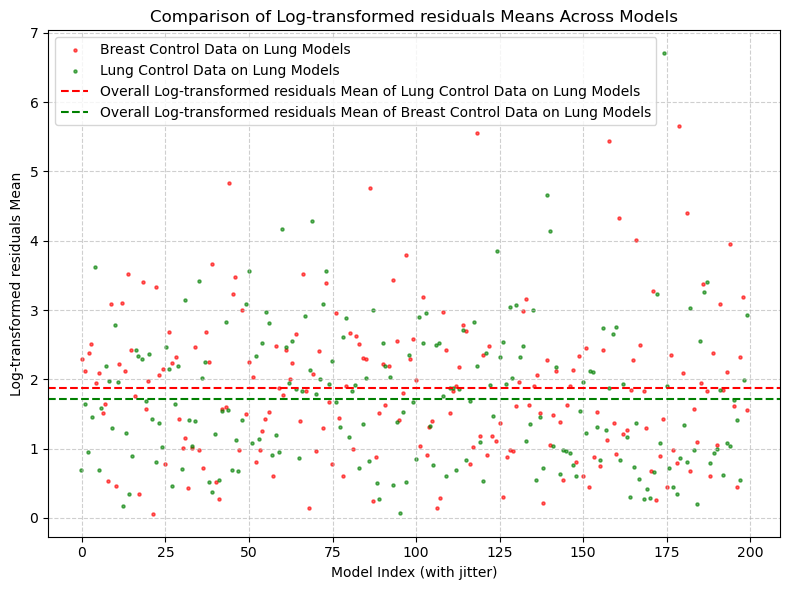

In [11]:
# Number of Models: 200 
# Number of control data to inclued per model: 30
plot_tissue_comparison_mean(200, 30, lll, blb, 
                       "Lung Control Data on Lung Models", 
                       "Breast Control Data on Lung Models",
                       "residuals",
                       log_transform=True)
